In [1]:
import datetime
import warnings

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats

In [2]:
%matplotlib inline

plt.style.use([
    'seaborn-notebook', 'seaborn-colorblind', {'figure.dpi': 96, 'grid.linestyle': ':'}
])

cc = plt.matplotlib.colors.colorConverter
for letter, prop in zip('bgrmyc', plt.rcParams['axes.prop_cycle']):
    cc.colors[letter] = cc.to_rgb(prop['color'])
cc.cache = {}

pd.options.display.max_rows = 6

warnings.filterwarnings('ignore',
                        category=UserWarning,
                        module='matplotlib.figure',
                        message='This figure includes Axes')

In [3]:
def make_colormap(colors):
    return mpl.colors.LinearSegmentedColormap.from_list('', colors)

---

In [4]:
def parse_date(field):
    return datetime.datetime.fromtimestamp(float(field))

trade_history = pd.read_table('../btc_jpy3.dat',
                              names=['id', 'timestamp', 'side', 'price', 'amount'],
                              index_col=0, parse_dates=[1], date_parser=parse_date)
trade_history

,timestamp,side,price,amount
id,,,,
47092048,2017-11-27 20:50:27,buy,1082418.0,0.132100
47092044,2017-11-27 20:50:27,buy,1082401.0,0.009000
47092047,2017-11-27 20:50:27,buy,1082418.0,0.060000
...,...,...,...,...
47288982,2017-11-28 06:09:11,buy,1076915.0,0.005000
47288983,2017-11-28 06:09:11,buy,1076981.0,0.008724
47288984,2017-11-28 06:09:12,sell,1076714.0,0.050000


---

In [5]:
def weighted_median(values, weights):
    values = np.sort(values)
    cumsum = np.cumsum(weights)
    cutoff = cumsum[-1] / 2.0
    return values[cumsum >= cutoff][0]

def weighted_median_price(df):
    return weighted_median(df['price'].values, df['amount'].values)

In [6]:
def weighted_mean(values, weights):
    return np.sum(values * weights) / np.sum(weights)

def weighted_mean_price(df):
    if len(df) == 0:
        return None
    return weighted_mean(df['price'].values, df['amount'].values)

In [7]:
def slope(values):
    return stats.linregress(np.arange(len(values)), values).slope

In [8]:
def bin_trades(trades, freq):
    groups = trades.groupby(pd.Grouper(key='timestamp', freq=freq))
    bins = pd.DataFrame.from_items([
        ('open',   groups.nth(0)['price']),
        ('close',  groups.nth(-1)['price']),
        ('min',    groups['price'].min()),
        ('mean',   groups.apply(weighted_mean_price)),
        ('max',    groups['price'].max()),
        ('amount', groups['amount'].sum()),
    ])
    return bins.fillna(method='ffill').fillna(method='bfill')

In [9]:
bin_freq = '5s'
bids = bin_trades(trade_history[trade_history['side'].eq('buy')], freq=bin_freq)
asks = bin_trades(trade_history[trade_history['side'].eq('sell')], freq=bin_freq)
totals = bin_trades(trade_history, freq=bin_freq)

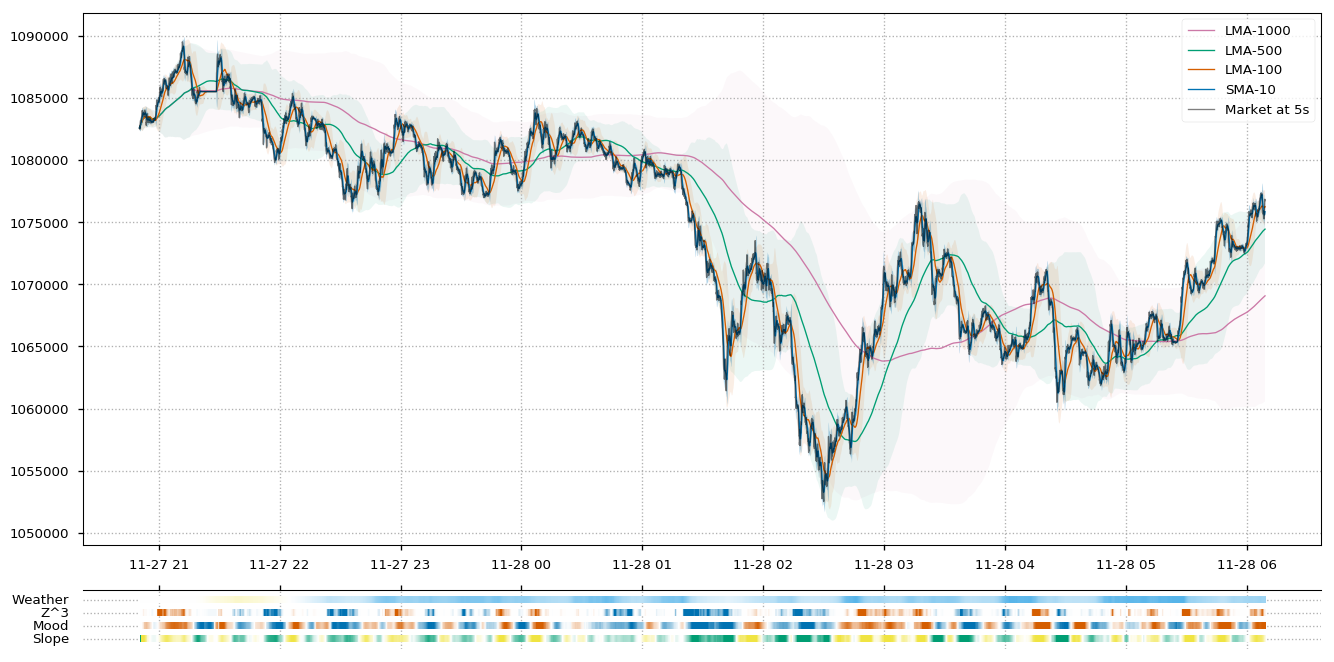

In [10]:
trades = totals
typical = 'mean'

longlonglong_mean = trades[typical].rolling(window=1000, min_periods=1).mean()
longlonglong_std = trades[typical].rolling(window=1000, min_periods=1).std()

longlong_mean = trades[typical].rolling(window=300, min_periods=1).mean()
longlong_std = trades[typical].rolling(window=300, min_periods=1).std()

long_mean = trades[typical].rolling(window=50, min_periods=1).mean()
long_std = trades[typical].rolling(window=50, min_periods=1).std()

short_mean = trades[typical].rolling(window=10, min_periods=1).mean()
short_std = trades[typical].rolling(window=10, min_periods=1).std()

weather = (longlong_mean - longlonglong_mean).rolling(window=8000, min_periods=1).mean() / longlong_std
mood = ((short_mean - long_mean) / short_std).rolling(window=100, min_periods=1).mean()
roll_slope = trades[typical].rolling(window=100, min_periods=1).apply(slope)

z_score = ((short_mean - longlong_mean) / longlong_std).dropna()

#
fig = plt.figure(figsize=(14, 7), tight_layout=True)
grid = plt.GridSpec(2, 1, height_ratios=[9, 1])

#
ax = fig.add_subplot(grid[0])

ax.fill_between(longlonglong_mean.index,
                longlonglong_mean + 2 * longlonglong_std,
                longlonglong_mean - 2 * longlonglong_std,
                lw=0, facecolor='m', alpha=0.05)
ax.plot(longlonglong_mean.index, longlonglong_mean,
        color='m', lw=1,
        label='LMA-1000')

ax.fill_between(longlong_mean.index,
                longlong_mean + 2 * longlong_std,
                longlong_mean - 2 * longlong_std,
                lw=0, facecolor='g', alpha=0.08)
ax.plot(longlong_mean.index, longlong_mean,
        color='g', lw=1,
        label='LMA-500')

ax.fill_between(long_mean.index,
                long_mean + 2 * long_std,
                long_mean - 2 * long_std,
                lw=0, facecolor='r', alpha=0.1)
ax.plot(long_mean.index, long_mean,
        color='r', lw=1,
        label='LMA-100')

ax.fill_between(short_mean.index,
                short_mean + 2 * short_std,
                short_mean - 2 * short_std,
                lw=0, facecolor='b', alpha=0.3)
ax.plot(short_mean.index, short_mean,
        color='b', lw=1,
        label='SMA-10')

ax.plot(trades.index, trades[typical],
        color='k', lw=1, alpha=0.5,
        label=('Market at ' + bin_freq))

xlim = ax.get_xlim()
ylim = ax.get_ylim()
xticks = ax.get_xticks()
yticks = ax.get_yticks()

ax.legend()
ax.grid(True)

#
ax = fig.add_subplot(grid[1])

xextent = mdates.date2num(trades.index[0]), mdates.date2num(trades.index[-1])

ax.matshow(weather.values.reshape(1, -1),
           vmin=-1, vmax=1, cmap=make_colormap('cwy'),
           extent=[xextent[0], xextent[1], 7, 8], aspect='auto', zorder=3)

ax.matshow((z_score**3).values.reshape(1, -1),
           vmin=-10, vmax=10, cmap=make_colormap('bwr'),
           extent=[xextent[0], xextent[1], 5, 6], aspect='auto', zorder=3)

ax.matshow(mood.values.reshape(1, -1),
           vmin=-3, vmax=3, cmap=make_colormap('bwr'),
           extent=[xextent[0], xextent[1], 3, 4], aspect='auto', zorder=3)

ax.matshow(roll_slope.values.reshape(1, -1),
           vmin=-50, vmax=50, cmap=make_colormap('gwy'),
           extent=[xextent[0], xextent[1], 1, 2], aspect='auto', zorder=3)

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='x', which='both', bottom='off')
ax.tick_params(axis='y', which='both', left='off', right='off')

ax.set_yticks([7.5, 5.5, 3.5, 1.5])
ax.set_yticklabels(['Weather', 'Z^3', 'Mood', 'Slope'], va='center')

ax.set_xticks(xticks)
ax.set_xticklabels([])

ax.set_xlim(*xlim)
ax.set_ylim(0, 9)

ax.grid(True)

pass

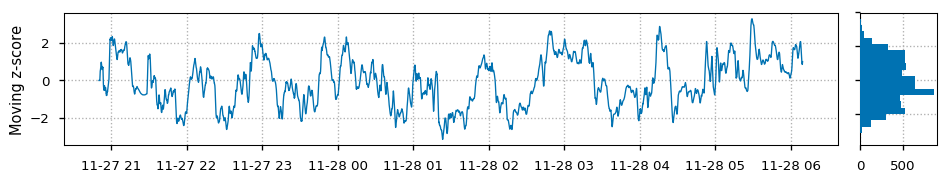

In [11]:
fig = plt.figure(figsize=(10, 2), tight_layout=True)
grid = plt.GridSpec(1, 2, width_ratios=[10, 1])

ax = fig.add_subplot(grid[0])
ax.plot(z_score.index, z_score, lw=1)
ax.grid(True)
ax.set_ylabel('Moving z-score')
z_range = ax.get_ylim()

ax = fig.add_subplot(grid[1])
ax.hist(z_score, bins=np.linspace(*z_range, num=20), orientation='horizontal', zorder=3)
ax.grid(True)
ax.set_yticklabels([])

pass